# Metrics III: GMM and SMM

Homework 1, MATLAB sample code

Chengzi Yi, 19/02/2022


In [3]:
% cd 'homework_2022/solution'
clear all
clc


In [4]:
% define parameters
rho = 0.6;
sigma = 1;
b = 1;
beta = 0.76;


In [5]:
%Tauchen method
ndd = 20;
D = 2;

% lower bond and upper bond for AR(1) process variable
smin = - D * sqrt(sigma ^ 2 / (1 - rho ^ 2));
smax = D * sqrt(sigma ^ 2 / (1 - rho ^ 2));

% set finite grids evenly spaced
d_grid = linspace(smin, smax, ndd);
d_grid = d_grid';
step = round((smax - smin) / (ndd - 1), 4);
% transition matrix
Pd = zeros(ndd, ndd);

% the transition matrix from state i to state j;
% rows are the current states and columns are the future states
for i = 1:ndd
    for j = 1:ndd
        if j == 1
            Pd(i,j) = normcdf((d_grid(j) + step/2 - rho*d_grid(i)) / sigma);
        elseif j == ndd
            Pd(i,j) = 1- normcdf((d_grid(j) - step/2 - rho*d_grid(i)) / sigma);
        else
            Pd(i,j) = normcdf((d_grid(j) + step/2 - rho*d_grid(i)) / sigma)...
                -normcdf((d_grid(j) - step/2 - rho*d_grid(i)) / sigma);
        end
    end
    % adjust the round-off error
    Pd(i,:) = Pd(i,:) / sum(Pd(i,:));
end

% shift the state values by the long-run mean
mu = b/(1-rho);
d_grid = d_grid + mu;


In [6]:
% VFI: for beta=0.76, suppose this is the true value
max_iter = 200;
tol = .000001;
Q = zeros(ndd, 1);

for j = 1:max_iter
    q_true = d_grid + beta * Pd * Q;
    error = abs((Q-q_true) ./ Q);

    if error <= tol
        break
    else
        Q=q_true;
    end
end


In [7]:
%VFI for different betas
BETA = [0.9, 0.6];
lenBETA = length(BETA);
q_BETA = zeros(ndd, lenBETA);
for i = 1:lenBETA
    bet = BETA(i);

    Q = zeros(ndd, 1);
    for j = 1:max_iter
        q = d_grid + bet * Pd * Q;
        error = abs((Q-q) ./ Q);

        if error <= tol
            break
        else
            Q=q;
        end
    end
    q_BETA(:,i) = q;
end



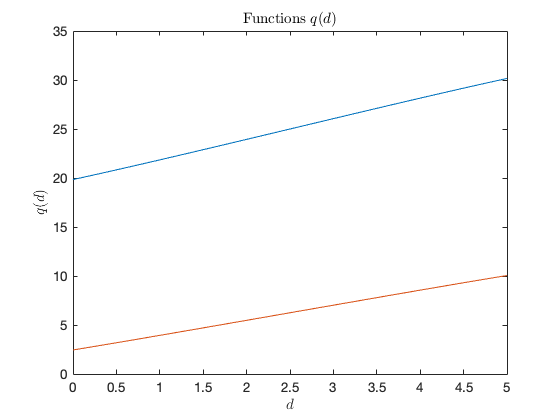

In [8]:
% Plot
figure
plot(d_grid, q_BETA(:,1))
hold on
plot(d_grid, q_BETA(:,2))
ylabel('$q(d)$','interpreter','latex')
xlabel('$d$','interpreter','latex')
title('Functions $q(d)$','interpreter','latex')


In [9]:
%%file homework_2022/solution/mc_sample_path.m
function [data, data_idx] = mc_sample_path(P, states, x0, T, seed)
    % simulate markov chain process
    % P and states are transition matrix and state values respectively
    rng(seed) % set seed for random generator
    P_dist = cumsum(P, 2); % cumsum of each row

    data_idx = zeros(T, 1);
    data_idx(1) = x0;

    ind = rand(T, 1);

    for t = 2:T
        i = data_idx(t-1);
        data_idx(t) = find(P_dist(i,:) >= ind(t), 1);
    end

    data = states(data_idx);

end


Created file '/Users/JuliaYI/Desktop/TA/homework_2022/solution/homework_2022/solution/mc_sample_path.m'.


In [10]:
% simulate the data
seed = 123;
T = 100;
d0 = 4;
[d_data, d_idx] = mc_sample_path(Pd, d_grid, d0, T, seed);
q_data = q_true(d_idx);
mm_dt = [mean(q_data), std(q_data)];


In [11]:
% wrap up the parameters
par.Pd = Pd;
par.d_grid = d_grid;
par.ndd = ndd;


In [12]:
%%file homework_2022/solution/Jfunc.m
function [stat, mm_sim]= Jfunc(beta0, T_hat, W, seed, par, mm_dt)
    % define a function that wrap up the procedures

    Pd = par.Pd; d_grid = par.d_grid; ndd = par.ndd;
    % simulation of the shock
    d0 = 10;
    [d_sim, idx_sim] = mc_sample_path(Pd, d_grid, d0, T_hat, seed);

    % vfi with beta being the guess beta0
    max_iter = 200;
    tol = .000001;

    Q = zeros(ndd, 1);

    iter = 0;
    for j = 1:max_iter
        q = d_grid + beta0 * Pd * Q;
        error = abs((Q-q) ./ Q);

        if error <= tol
            break
        else
            Q=q;
            iter = iter + 1;
        end
    end

    % simulated moments
    q_sim = q(idx_sim);
    mm_sim = [mean(q_sim), std(q_sim)];

    % stat: this is what we want to minimize
    stat = (mm_dt - mm_sim) * W * (mm_dt - mm_sim)';
end


Created file '/Users/JuliaYI/Desktop/TA/homework_2022/solution/homework_2022/solution/Jfunc.m'.


In [14]:
% use indentity matrix as weighting matrix
W_mat = eye(2);
T_hat = 1000;
seed_sim = 222; %use a different seed than the data generating seed

% find beta_hat by fminsearch
options = optimset('MaxFunEvals',10000,'MaxIter',10000,'Display','off');
b0 = .88; %search from here
f = @(b)Jfunc(b, T_hat, W_mat, seed_sim, par, mm_dt);

est = fminsearch(f, b0, options);
disp(' results from bounded search')
disp(est)

 results from bounded search
    0.7614

